###setup

In [1]:
%matplotlib inline

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from showit import image, tile
import matplotlib.animation as animation

In [4]:
import thunder

In [5]:
from os.path import join, exists
from os import mkdir, makedirs

###set directory and session information

In [6]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [7]:
key = '2016-04-06-17'
name = 'anm-0333650'

In [8]:
path = join(directory, 'processed', name, key)
print exists(path)

True


In [9]:
pixelsPerUm = 600.0/512 #600.0/512
frameRate = 9.6 #10
scaleBar = 100

###create savepath

In [10]:
savepath = join(path, 'movies')
if not exists(savepath):
    makedirs(savepath)

###load data

In [11]:
data = thunder.images.frombinary(join(path, 'registered'), engine=sc)

In [12]:
data

Images
mode: spark
dtype: int16
shape: (213, 512, 512, 4)

In [13]:
data.cache();

###transform data

In [14]:
from numpy import convolve, ones

In [15]:
filtered = data.median_filter((2, 2, 1))

In [16]:
downsampleSpace = 1
downsampleTime = 5

In [17]:
def smooth(s):
    r = convolve(s, ones(downsampleTime)/downsampleTime, 'same').astype('int16')
    return r[::downsampleTime]

In [18]:
smoothed = filtered.map_as_series(smooth)

In [19]:
result = smoothed.toarray()

In [187]:
#smoothed.tobinary(savepath, overwrite=True)
#result = result.swapaxes(1,2).swapaxes(2,3)

###create movie

In [20]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

###Extract single plane

In [233]:
plane = 0
if len(result.shape) == 3:
    plane = 0
    movie = result
else:
    movie = result[:,plane,:,:]

In [234]:
means = movie.mean()

In [235]:
means

539.20635041821902

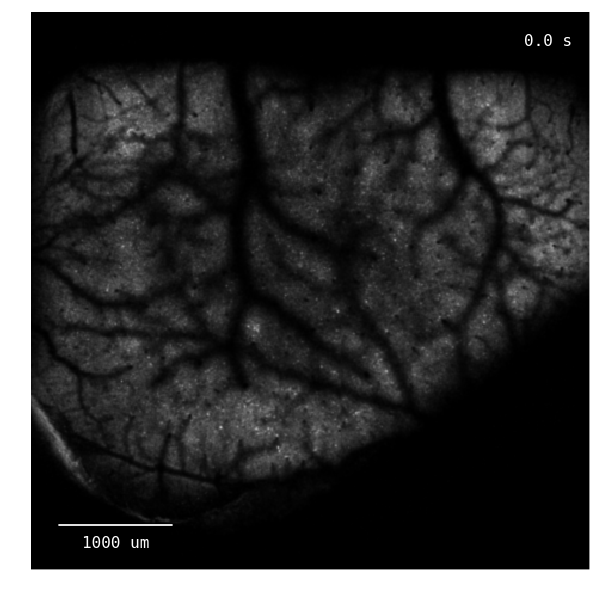

In [236]:
fig = plt.figure(figsize=[10,10])
ax = plt.gca()
im = image(movie[0,:,:], clim=(0, 4000), ax=ax)

frame = 0
time = ax.text(.97*movie.shape[2], .06*movie.shape[1], '%.1f s' % (frame/frameRate*downsampleTime), color='white', fontsize=16, ha='right', fontdict={'family': 'monospace'});
ax.plot([.05*movie.shape[2], .05*movie.shape[2]+scaleBar/pixelsPerUm/downsampleSpace], [.92*movie.shape[1], .92*movie.shape[1]], 'w');
sclae = ax.text(.05*movie.shape[2]+scaleBar/pixelsPerUm/2/downsampleSpace, .96*movie.shape[1], '%d um' % scaleBar, color='white', fontsize=16, ha='center', fontdict={'family': 'monospace'});
plt.xlim([0, movie.shape[2]]);
plt.ylim([movie.shape[1], 0]);

In [237]:
nframes = movie.shape[0]-10

def update(frame):
    im.set_array(movie[10+frame,:,:])
    time.set_text('%.1f s' % (frame/frameRate*downsampleTime))

ani = animation.FuncAnimation(fig, update, nframes, blit=False)
ani.save(join(savepath, 'movie_dsGF0.75_ts3-%d.mp4' % plane), writer=writer)

####tiled 4-planes

In [21]:
movie = result

In [22]:
means = movie.mean(axis=0).mean(axis=0).mean(axis=0)

In [23]:
means

array([ 284.68024312,  393.64342312,   64.40045556,  359.63162125])

In [24]:
movie.shape

(43, 512, 512, 4)

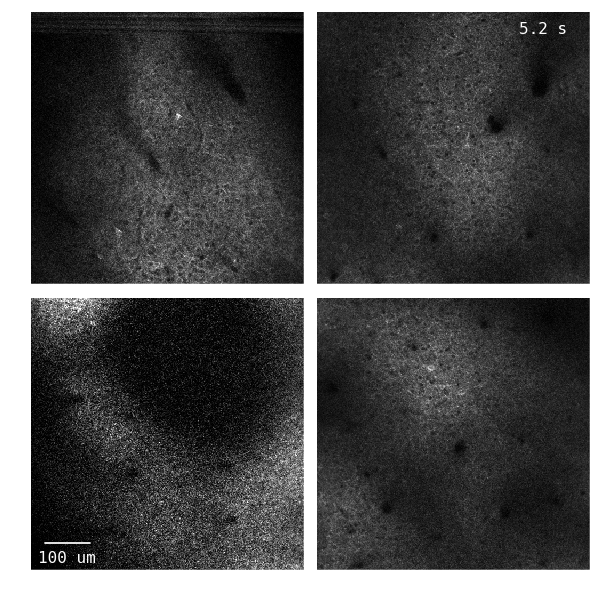

In [25]:
fig = plt.figure(figsize=[10,10])
axes, g = tile(movie[0,:,:], clim=[(0, mean*4) for mean in means], axis=2, fig=fig)

frame = 10
time = g[1].text(.92*movie.shape[2], .08*movie.shape[1], '%.1f s' % (frame/frameRate*downsampleTime), color='white', fontsize=16, ha='right', fontdict={'family': 'monospace'});
g[2].plot([.05*movie.shape[2], .05*movie.shape[2]+scaleBar/pixelsPerUm/downsampleSpace], [.9*movie.shape[1], .9*movie.shape[1]], 'w');
g[2].text(.05*movie.shape[2]+scaleBar/pixelsPerUm/2/downsampleSpace, .975*movie.shape[1], '%d um' % scaleBar, color='white', fontsize=16, ha='center', fontdict={'family': 'monospace'});
for i in range(4):
    g[i].set_xlim([0, movie.shape[2]]);
    g[i].set_ylim([movie.shape[1], 0]);

In [26]:
nframes = movie.shape[0]-2

def update(frame):
    [axes[i].set_array(movie[frame+1, :, :, i]) for i in range(4)]
    time.set_text('%.1f s' % ((frame+1)/frameRate*downsampleTime))

ani = animation.FuncAnimation(fig, update, nframes, blit=False)
ani.save(join(savepath, 'tiled_ds2_ts5.mp4'), writer=writer)